### 1. Imports

In [8]:
import os
import sys
import shutil
import numpy as np
import pandas as pd

import tensorflow as tf


import itertools
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out UserWarning from specific module
warnings.filterwarnings("ignore", message="`layer.apply` is deprecated", category=UserWarning)


#tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (map, ndcg_at_k, precision_at_k, recall_at_k)
from recommenders.utils.constants import SEED as DEFAULT_SEED
#from recommenders.utils.notebook_utils import store_metadata

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

from sklearn.model_selection import train_test_split

System version: 3.9.18 (main, Sep 11 2023, 08:25:10) 
[Clang 14.0.6 ]
Pandas version: 1.5.3
Tensorflow version: 2.15.0


### 2. Setting Up Parameters

In [9]:
# top k items to recommend
TOP_K = 10

# Select  data size: 100k, 1m, 10m, or 20m
DATA_SIZE = 100000

# Model parameters
EPOCHS = 100 # ! Changed from 100 because it was taking forever
BATCH_SIZE = 256

SEED = DEFAULT_SEED  # Set None for non-deterministic results

### 3. Loading Dataframe


In [10]:
# * Load & Set Up Dataframe
original_dataframe = pd.read_csv('spotify_songs.csv')
CF_DF = original_dataframe

In [11]:
# Create Random Input Playlist of 10 Songs
input_samples = CF_DF.sample(n=10)
input_samples.to_csv('input.csv', index=False)

In [12]:
# Adding InputPlaylist to Dataframe
inputPlaylist = pd.read_csv('input.csv')
inputPlaylist['playlist_id'] = 'input_playlist'
inputPlaylist['playlist_name'] = 'input_playlist'

CF_DF = pd.concat([CF_DF, inputPlaylist], ignore_index=True)
df = CF_DF[['playlist_id', 'track_id']]

df.tail(10)

,playlist_id,track_id
32833,input_playlist,0DIIKoJoDnY1TKvrTQPck8
32834,input_playlist,0FNtBIL5lHcn7pLV7P6TGv
32835,input_playlist,05QSh6nyG3AEBVUTrJPgIk
32836,input_playlist,2gpEHrWOXBpeAIGORiBWw5
32837,input_playlist,5skLVBXJf3VbnauZUI29pK
32838,input_playlist,2zgdBHyyjJXmFwQyCRgBlJ
32839,input_playlist,1f1QPwS422JMbg2aRW66bw
32840,input_playlist,4t8bZ8dxZtatpjOpBrAnUW
32841,input_playlist,4m0q0xQ2BNl9SCAGKyfiGZ
32842,input_playlist,2NEjPjHPuTjUqQ8MoIWi0Z


In [13]:
# Create a DataFrame with all possible combinations of playlist_id and track_id
unique_playlists = df['playlist_id'].unique()
unique_tracks = df['track_id'].unique()

# Create a dataframe to store all combinations of playlist and track
all_combinations = pd.DataFrame([(playlist_id, track_id) for playlist_id in unique_playlists for track_id in unique_tracks],columns=['playlist_id', 'track_id'])
df = df.assign(rating=1)

# Merge with the original dataframe to check for existence
merged_df = all_combinations.merge(df, on=['playlist_id', 'track_id'], how='left')
#merged_df.drop_duplicates(subset=['playlist_id', 'track_id'], keep='first', inplace=True, ignore_index=True)

# Replace NaN values with 0 to represent absence of track in playlist
merged_df['rating'] = merged_df['rating'].fillna(0).astype(int)

# Select relevant columns
used_df = merged_df.loc[:, ['playlist_id', 'track_id', 'rating']]

# Filter out entries with playlist_id equal to 'input_user'
reg_df = used_df[used_df['playlist_id'] != 'input_playlist']
input_user_df = used_df[used_df['playlist_id'] == 'input_playlist']
input_user_df = input_user_df.sample(n=1000)
input_length = len(input_user_df)

# Step 2: Sample 10,000 - len(input_playlist) rows from reg_df
num_samples = 10000 - input_length
sampled_df = reg_df.sample(n=num_samples, replace=False)

# Step 3: Add the rows with input_playlist back to reg_df
concatenated_df = pd.concat([sampled_df, input_user_df], ignore_index=True)


# Factorizing 
concatenated_df['userID'], og_playlist_id = pd.factorize(concatenated_df['playlist_id'])
concatenated_df['itemID'], og_item_id  = pd.factorize(concatenated_df['track_id'])

UI_DF = concatenated_df[['userID', 'itemID', 'rating']]

#UI_DF.head()
print(len(UI_DF))
UI_DF.tail(10)

10000


,userID,itemID,rating
9990,471,8413,0
9991,471,8414,0
9992,471,8415,0
9993,471,8416,0
9994,471,5640,0
9995,471,4340,0
9996,471,6060,0
9997,471,2482,0
9998,471,8417,0
9999,471,8418,0


In [14]:
#---USERS---#
# Get Playlist Numbers 
User_Num = concatenated_df[['userID', 'playlist_id']].copy()
User_Num.drop_duplicates(subset='userID', inplace=True)
print('User Reference Length: ', len(User_Num))

# Get Playlist Names 
User_Name = CF_DF[['playlist_id', 'playlist_name']].copy()
User_Name.drop_duplicates(subset='playlist_id', inplace=True)

# Merge Playlist Num & Names
User_Ref = User_Num.merge(User_Name, how = 'left')
print('User Reference Length After Merge: ', len(User_Ref))

#---ITEMS---#
# Get Item Numbers
Item_Num = concatenated_df[['itemID', 'track_id']].copy()
Item_Num.drop_duplicates(subset='itemID', inplace=True)
print('Item Reference Length: ',len(Item_Num))

# Get Item Name & Artist
Item_Name_Artist = CF_DF[['track_id', 'track_name', 'track_artist']].copy()
Item_Name_Artist.drop_duplicates(subset='track_id', inplace=True)

# Merge Item Num & Names/Artists
Item_Ref = Item_Num.merge(Item_Name_Artist, how = 'left')
print('Item Reference Length After Merge: ',len(Item_Ref))


User Reference Length:  472
User Reference Length After Merge:  472
Item Reference Length:  8419
Item Reference Length After Merge:  8419


### 4. Training & Testing Split

In [15]:
#train, test = python_chrono_split(CF_DF, 0.75)
train, test = train_test_split(UI_DF, test_size=0.25, random_state=SEED)

In [16]:
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [17]:
leave_one_out_test = test.groupby("userID").last().reset_index()

In [18]:
train_file = "./splits/train2.csv"
test_file = "./splits/test2.csv"
leave_one_out_test_file = "./splits/leave_one_out_test2.csv"
train = train.sort_values(by='userID')
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

In [19]:
leave_one_out_test.to_csv(leave_one_out_test_file, index=False)

### 5. NCF Dataset 

In [20]:
data = NCFDataset(train_file=train_file, test_file=leave_one_out_test_file, seed=SEED, overwrite_test_file_full=True)

INFO:recommenders.models.ncf.dataset:Indexing ./splits/train2.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./splits/leave_one_out_test2.csv ...
INFO:recommenders.models.ncf.dataset:Creating full leave-one-out test file ./splits/leave_one_out_test2_full.csv ...
100%|██████████| 304/304 [00:02<00:00, 104.74it/s]
INFO:recommenders.models.ncf.dataset:Indexing ./splits/leave_one_out_test2_full.csv ...


### 6. Non-Pre Trained

In [21]:
fact_results = []
input_recs = []

facts = [3, 6, 9, 12]
for Factor_Num in facts:
    
    print(f'######################### Factor Num: {Factor_Num} #########################################')

    fact_result_row = []

    # add epoch number
    fact_result_row.append(facts)

    print('---TRAIN---')
    model = NCF(
            n_users=data.n_users, 
            n_items=data.n_items,
            model_type="NeuMF",
            n_factors=Factor_Num,
            layer_sizes=[16,8,4],
            n_epochs= 100,
            batch_size=BATCH_SIZE,
            learning_rate=1e-3,
            verbose=10,
            seed=SEED
        )

    with Timer() as train_time:
            model.fit(data)
            
    print("Took {} seconds for training.".format(train_time.interval))

    print(' ')

    print(' ')

    print('--- PREDICTIONS ---')

    predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
            for (_, row) in test.iterrows()]

    predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])

    # Group predictions by userID and rank remaining items based on predicted scores
    top_k_recs = predictions.groupby('userID').apply(lambda x: x.nlargest(TOP_K, 'prediction')).reset_index(drop=True)

    print('--- PREDICTIONS FOR INPUT USER ---')
    input_user_id = (len(User_Ref)) - 1 
    top_k_user = top_k_recs[(top_k_recs['userID'] == input_user_id)]

    row = User_Ref.loc[(User_Ref['userID'] == input_user_id)]

    item_list = top_k_user['itemID'].values

    input_rec_row = []
    input_rec_row.append(Factor_Num)
    
    i = 1
    print('Top 10 Recommendations For You:\n')
    for item in item_list:
        rec_info = []
        row = Item_Ref.loc[(Item_Ref['itemID'] == item)]

        name = row['track_name'].values[0]
        artist = row['track_artist'].values[0]
        
        rec_info.append(name)
        rec_info.append(artist)
        input_rec_row.append(rec_info)

        print(f"{i}.'{name}' - {artist}")
        i += 1
    
    input_recs.append(input_rec_row)

    print(' ')

    print('--- GENERIC EVALUATION ---')
    with Timer() as test_time:
        users, items, preds = [], [], []
        item = list(train.itemID.unique())
        for user in train.userID.unique():
            user = [user] * len(item) 
            users.extend(user)
            items.extend(item)
            preds.extend(list(model.predict(user, item, is_list=True)))

        all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

        merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
        all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

    print("Took {} seconds for prediction.".format(test_time.interval))

    eval_map = map(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

    print("MAP:\t%f" % eval_map,
        "NDCG:\t%f" % eval_ndcg,
        "Precision@K:\t%f" % eval_precision,
        "Recall@K:\t%f" % eval_recall, sep='\n')

    fact_result_row.append(eval_map)
    fact_result_row.append(eval_ndcg)
    fact_result_row.append(eval_precision)
    fact_result_row.append(eval_recall)

    print(' ')

    print('--- LEAVE-ONE-OUT EVALUATION ---')
    k = TOP_K

    ndcgs = []
    hit_ratio = []

    for b in data.test_loader():
        user_input, item_input, labels = b
        output = model.predict(user_input, item_input, is_list=True)

        output = np.squeeze(output)
        rank = sum(output >= output[0])
        if rank <= k:
            ndcgs.append(1 / np.log(rank + 1))
            hit_ratio.append(1)
        else:
            ndcgs.append(0)
            hit_ratio.append(0)

    eval_ndcg = np.mean(ndcgs)
    eval_hr = np.mean(hit_ratio)

    print("HR:\t%f" % eval_hr)
    print("NDCG:\t%f" % eval_ndcg)

    fact_result_row.append(eval_ndcg)
    fact_result_row.append(eval_hr)

    print(' ')
      
    fact_results.append(fact_result_row)

    print(' ')
    print(' ')


######################### Factor Num: 3 #########################################
---TRAIN---


2024-04-23 22:10:37.709857: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [2.25s]: train_loss = 0.001582 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.45s]: train_loss = 0.000305 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [2.27s]: train_loss = 0.000336 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.86s]: train_loss = 0.000217 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [1.58s]: train_loss = 0.000157 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [1.15s]: train_loss = 0.000189 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [1.49s]: train_loss = 0.000176 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [1.20s]: train_loss = 0.000150 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [1.22s]: train_loss = 0.000107 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [1.25s]: train_loss = 0.000127 


Took 160.537152084 seconds for training.
 
 
--- PREDICTIONS ---
--- PREDICTIONS FOR INPUT USER ---
Top 10 Recommendations For You:

1.'Beatiful Day' - Rob Stepwart
2.'Sensitivity' - Ralph Tresvant
3.'Fortunate Son' - Creedence Clearwater Revival
4.'Blah Blah Blah' - Armin van Buuren
5.'Friedhof der Kuscheltiere' - Manuellsen
6.'Runaway (U & I)' - Galantis
7.'Summer Of Love - Ian Carey Radio Remix' - Sunloverz
8.'Singular' - Orgânico
9.'Squeeze' - Ghostemane
10.'Band On The Run - Remastered 2010' - Paul McCartney
 
--- GENERIC EVALUATION ---
Took 15.865740625 seconds for prediction.
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000
 
--- LEAVE-ONE-OUT EVALUATION ---
HR:	0.108553
NDCG:	0.075770
 
 
 
######################### Factor Num: 6 #########################################
---TRAIN---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.26s]: train_loss = 0.001003 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.41s]: train_loss = 0.000391 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.36s]: train_loss = 0.000114 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.30s]: train_loss = 0.000053 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [1.48s]: train_loss = 0.000177 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [2.56s]: train_loss = 0.000116 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [1.47s]: train_loss = 0.000022 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [1.62s]: train_loss = 0.000030 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [1.61s]: train_loss = 0.000023 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [1.39s]: train_loss = 0.000027 


Took 157.70052516700002 seconds for training.
 
 
--- PREDICTIONS ---
--- PREDICTIONS FOR INPUT USER ---
Top 10 Recommendations For You:

1.'If I Could Turn Back Time' - Cher
2.'I Want U' - Loosid
3.'Ligaya' - Eraserheads
4.'I Wanna Know (feat. Bea Miller)' - NOTD
5.'Hold on for Dear Life' - Night Cap
6.'Sayonara - Young Bombs Remix / Radio Edit' - Rebecca & Fiona
7.'Me llama' - Beret
8.'Bésame' - Gian Varela
9.'Sunday Morning' - The Velvet Underground
10.'El Rito - Remasterizado 2007' - Soda Stereo
 
--- GENERIC EVALUATION ---
Took 17.405399832999933 seconds for prediction.
MAP:	0.000329
NDCG:	0.000780
Precision@K:	0.000329
Recall@K:	0.001645
 
--- LEAVE-ONE-OUT EVALUATION ---
HR:	0.101974
NDCG:	0.060786
 
 
 
######################### Factor Num: 9 #########################################
---TRAIN---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.69s]: train_loss = 0.001583 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [2.33s]: train_loss = 0.000336 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [2.17s]: train_loss = 0.000344 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.98s]: train_loss = 0.000269 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [2.67s]: train_loss = 0.000114 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [1.36s]: train_loss = 0.000086 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [1.47s]: train_loss = 0.000379 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [1.33s]: train_loss = 0.000175 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [1.76s]: train_loss = 0.000155 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [1.51s]: train_loss = 0.000130 


Took 195.73918924999998 seconds for training.
 
 
--- PREDICTIONS ---
--- PREDICTIONS FOR INPUT USER ---
Top 10 Recommendations For You:

1.'Snake Charmer - 1930 Version' - Parov Stelar
2.'Hold on for Dear Life' - Night Cap
3.'Bad Blood' - Nao
4.'Ligaya' - Eraserheads
5.'I Wanna Know (feat. Bea Miller)' - NOTD
6.'Sunday Morning' - The Velvet Underground
7.'Alright - 7" House Mix With Rap' - Janet Jackson
8.'Friedhof der Kuscheltiere' - Manuellsen
9.'No Podemos - Remix' - Ele A El Dominio
10.'Sayonara - Young Bombs Remix / Radio Edit' - Rebecca & Fiona
 
--- GENERIC EVALUATION ---
Took 18.78593187499996 seconds for prediction.
MAP:	0.000183
NDCG:	0.000607
Precision@K:	0.000329
Recall@K:	0.001645
 
--- LEAVE-ONE-OUT EVALUATION ---
HR:	0.078947
NDCG:	0.048247
 
 
 
######################### Factor Num: 12 #########################################
---TRAIN---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.99s]: train_loss = 0.001087 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [2.06s]: train_loss = 0.000314 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [3.61s]: train_loss = 0.000138 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.33s]: train_loss = 0.000097 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [1.17s]: train_loss = 0.000067 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.77s]: train_loss = 0.000025 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [1.40s]: train_loss = 0.000012 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.73s]: train_loss = 0.000064 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [1.00s]: train_loss = 0.000223 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.99s]: train_loss = 0.000099 


Took 155.05384233299992 seconds for training.
 
 
--- PREDICTIONS ---
--- PREDICTIONS FOR INPUT USER ---
Top 10 Recommendations For You:

1.'No Podemos - Remix' - Ele A El Dominio
2.'Runaway (U & I)' - Galantis
3.'Singular' - Orgânico
4.'I Want U' - Loosid
5.'Dando Saltos' - Métricas Frías
6.'Somos Dos' - Bomba Estéreo
7.'Lullaby For My Insomniac' - James Blake
8.'Roller Coaster' - blink-182
9.'If I Could Turn Back Time' - Cher
10.'I Wanna Know (feat. Bea Miller)' - NOTD
 
--- GENERIC EVALUATION ---
Took 16.423561916999915 seconds for prediction.
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000
 
--- LEAVE-ONE-OUT EVALUATION ---
HR:	0.111842
NDCG:	0.064483
 
 
 


### 7. Pre-Trained 

In [24]:
fact_results_pretrained = []
input_recs = []

facts = [3, 6, 9, 12]

for Factor_Num in facts:

    print(f'############ Number of Factors: {Factor_Num} #########')

    fact_result_row = []

    print(' ')

    print('--- STORE MLP PARAMETER ---')
    model = NCF(
        n_users=data.n_users, 
        n_items=data.n_items,
        model_type="MLP",
        n_factors=Factor_Num,
        layer_sizes=[16,8,4],
        n_epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=1e-3,
        verbose=10,
        seed=SEED
    )

    with Timer() as train_time:
        model.fit(data)

    print("Took {} seconds for training.".format(train_time.interval))

    model.save(dir_name=".pretrain_fact/MLP")

    print(' ')

    print('--- STORE GMF PARAMETER ---')
    model = NCF(
        n_users=data.n_users, 
        n_items=data.n_items,
        model_type="GMF",
        n_factors=Factor_Num,
        layer_sizes=[16,8,4],
        n_epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=1e-3,
        verbose=10,
        seed=SEED
    )

    with Timer() as train_time:
        model.fit(data)

    print("Took {} seconds for training.".format(train_time.interval))

    model.save(dir_name=".pretrain_fact/GMF")

    with Timer() as train_time:
            model.fit(data)

    print("Took {} seconds for training.".format(train_time.interval))

    print(' ')

    print('--- GENERIC EVALUATION ---')
    with Timer() as test_time:

        users, items, preds = [], [], []
        item = list(train.itemID.unique())
        for user in train.userID.unique():
            user = [user] * len(item) 
            users.extend(user)
            items.extend(item)
            preds.extend(list(model.predict(user, item, is_list=True)))

        all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

        merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
        all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

    print("Took {} seconds for prediction.".format(test_time.interval))
    eval_map2 = map(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_ndcg2 = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_precision2 = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_recall2 = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

    print("MAP:\t%f" % eval_map2,
        "NDCG:\t%f" % eval_ndcg2,
        "Precision@K:\t%f" % eval_precision2,
        "Recall@K:\t%f" % eval_recall2, sep='\n')

    fact_result_row.append(eval_map2)
    fact_result_row.append(eval_ndcg2)
    fact_result_row.append(eval_precision2)
    fact_result_row.append(eval_recall2)

    fact_results_pretrained.append(fact_result_row)



############ Number of Factors: 3 #########
 
--- STORE MLP PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.72s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.63s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.70s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.59s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.81s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.65s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.87s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [1.00s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.57s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.66s]: train_loss = 0.693147 


Took 75.58558241599985 seconds for training.
 
--- STORE GMF PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.90s]: train_loss = 0.058550 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.64s]: train_loss = 0.006445 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.67s]: train_loss = 0.002518 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.77s]: train_loss = 0.001586 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.75s]: train_loss = 0.001196 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.59s]: train_loss = 0.001068 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.56s]: train_loss = 0.000973 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.69s]: train_loss = 0.000824 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [1.11s]: train_loss = 0.000699 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.67s]: train_loss = 0.000616 


Took 77.28852204199984 seconds for training.


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.66s]: train_loss = 0.000451 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.94s]: train_loss = 0.000327 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.85s]: train_loss = 0.000255 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.59s]: train_loss = 0.000120 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.65s]: train_loss = 0.000087 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.64s]: train_loss = 0.000036 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.63s]: train_loss = 0.000114 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.56s]: train_loss = 0.000015 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.55s]: train_loss = 0.000012 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.53s]: train_loss = 0.000053 


Took 67.64601195799969 seconds for training.
 
--- GENERIC EVALUATION ---
Took 8.856657249999898 seconds for prediction.
MAP:	0.000548
NDCG:	0.001008
Precision@K:	0.000329
Recall@K:	0.001645
############ Number of Factors: 6 #########
 
--- STORE MLP PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.57s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.60s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.55s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.59s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.73s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.58s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.70s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.63s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.61s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [1.01s]: train_loss = 0.693147 


Took 73.48221629099999 seconds for training.
 
--- STORE GMF PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.37s]: train_loss = 0.027763 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.47s]: train_loss = 0.003905 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.83s]: train_loss = 0.001856 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.27s]: train_loss = 0.001313 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [1.11s]: train_loss = 0.001189 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [1.84s]: train_loss = 0.000991 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [1.13s]: train_loss = 0.000857 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.67s]: train_loss = 0.000664 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.60s]: train_loss = 0.000460 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.93s]: train_loss = 0.000261 


Took 181.60846408299994 seconds for training.


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.90s]: train_loss = 0.000125 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.22s]: train_loss = 0.000057 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.55s]: train_loss = 0.000027 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.96s]: train_loss = 0.000021 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [1.01s]: train_loss = 0.000059 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [1.43s]: train_loss = 0.000008 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.65s]: train_loss = 0.000004 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.64s]: train_loss = 0.000002 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.66s]: train_loss = 0.000301 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.60s]: train_loss = 0.000002 


Took 77.5754040830002 seconds for training.
 
--- GENERIC EVALUATION ---
Took 10.279999792000126 seconds for prediction.
MAP:	0.000548
NDCG:	0.001008
Precision@K:	0.000329
Recall@K:	0.001645
############ Number of Factors: 9 #########
 
--- STORE MLP PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.72s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.70s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.69s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.84s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.67s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.64s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.53s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.81s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.95s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.68s]: train_loss = 0.693147 


Took 77.09962966700004 seconds for training.
 
--- STORE GMF PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.62s]: train_loss = 0.018213 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.68s]: train_loss = 0.003097 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.76s]: train_loss = 0.001674 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.78s]: train_loss = 0.001223 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.58s]: train_loss = 0.001017 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.55s]: train_loss = 0.000839 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.68s]: train_loss = 0.000631 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.68s]: train_loss = 0.000349 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.57s]: train_loss = 0.000214 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.95s]: train_loss = 0.000075 


Took 76.23368224999967 seconds for training.


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.67s]: train_loss = 0.000081 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.76s]: train_loss = 0.000017 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.89s]: train_loss = 0.000038 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.58s]: train_loss = 0.000036 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.73s]: train_loss = 0.000038 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.61s]: train_loss = 0.000003 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.58s]: train_loss = 0.000002 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [1.23s]: train_loss = 0.000009 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [1.20s]: train_loss = 0.000002 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.83s]: train_loss = 0.000005 


Took 74.51152920899995 seconds for training.
 
--- GENERIC EVALUATION ---
Took 10.16603883300013 seconds for prediction.
MAP:	0.000329
NDCG:	0.000780
Precision@K:	0.000329
Recall@K:	0.001645
############ Number of Factors: 12 #########
 
--- STORE MLP PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.74s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.68s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.58s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.62s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.99s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.62s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.55s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.97s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.76s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.59s]: train_loss = 0.693147 


Took 76.23101399999996 seconds for training.
 
--- STORE GMF PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.75s]: train_loss = 0.013879 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.61s]: train_loss = 0.002598 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.71s]: train_loss = 0.001524 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.81s]: train_loss = 0.001139 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [1.74s]: train_loss = 0.000877 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.93s]: train_loss = 0.000580 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.90s]: train_loss = 0.000345 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.71s]: train_loss = 0.000139 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.60s]: train_loss = 0.000074 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [1.41s]: train_loss = 0.000022 


Took 87.00261508299991 seconds for training.


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.97s]: train_loss = 0.000009 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.65s]: train_loss = 0.000005 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.01s]: train_loss = 0.000048 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.60s]: train_loss = 0.000058 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.69s]: train_loss = 0.000020 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.90s]: train_loss = 0.000001 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.77s]: train_loss = 0.000001 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.66s]: train_loss = 0.000006 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.91s]: train_loss = 0.000012 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [1.16s]: train_loss = 0.000034 


Took 81.1226073329999 seconds for training.
 
--- GENERIC EVALUATION ---
Took 9.344234250000227 seconds for prediction.
MAP:	0.000274
NDCG:	0.000718
Precision@K:	0.000329
Recall@K:	0.001645


### 8. Visualizations

In [31]:
header = ['Factor Count', 'GE MAP', 'GE NDCG', 'GE PrecK', 'GE RecK', 'LOO HR', 'LOO NDCG',]

filename = 'fact_results.csv'

with open(filename, 'w') as file:
    for header in header:
        file.write(str(header)+', ')
    file.write('\n')

    
    for row in fact_results:
        for x in row:
            file.write(str(x) + ', ')
        file.write('\n')

In [32]:
header = ['Factor Count', 'PTGE MAP', 'PTGE NDCG', 'PTGE PrecK', 'PTGE RecK']

filename = 'fact_results_pretrained.csv'

with open(filename, 'w') as file:
    for header in header:
        file.write(str(header)+', ')
    file.write('\n')

    
    for row in fact_results_pretrained:
        for x in row:
            file.write(str(x) + ', ')
        file.write('\n')

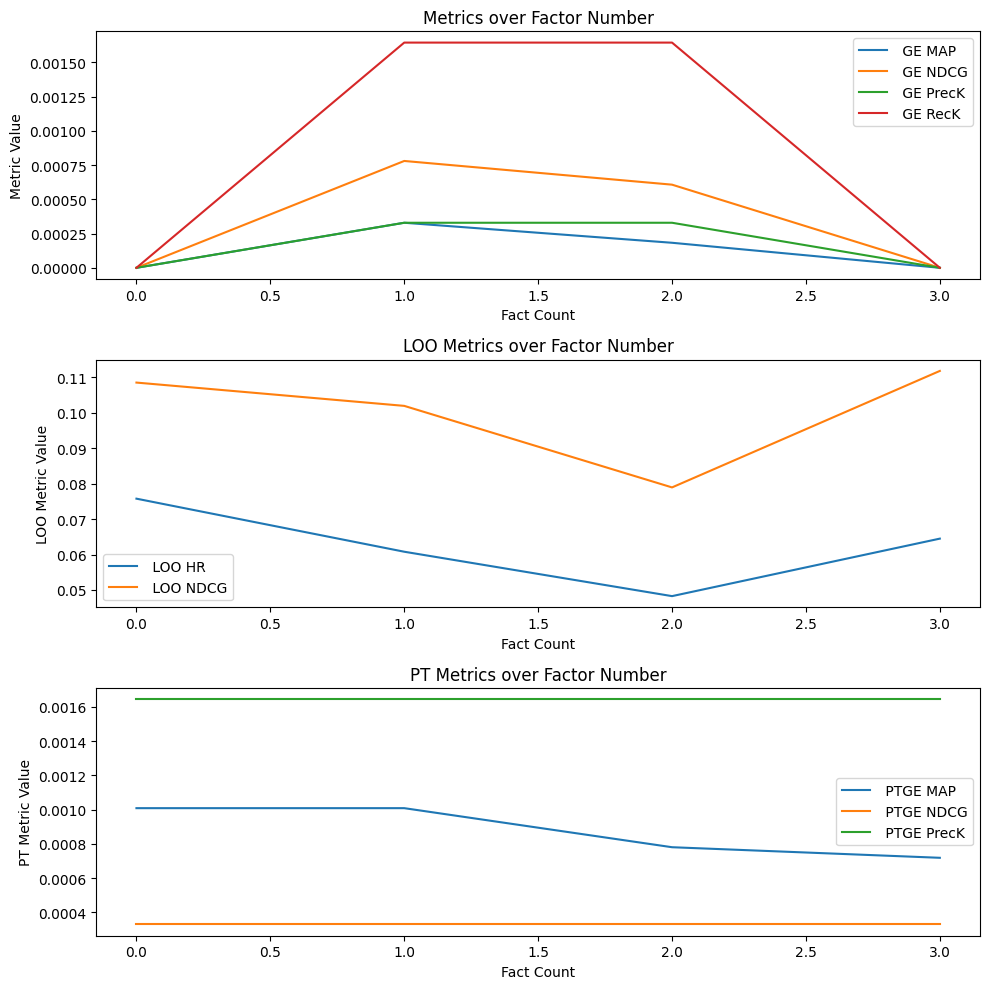

In [45]:
facts_df = pd.read_csv("fact_results.csv") 
pt_facts_df = pd.read_csv("fact_results_pretrained.csv") 


facts_df_rs = facts_df.reset_index()

# Set up the plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

# Plot using Seaborn lineplot
sns.lineplot(data=facts_df_rs[[' GE MAP',' GE NDCG',' GE PrecK',' GE RecK']], dashes=False, ax=axes[0])
axes[0].set_title('Metrics over Factor Number')
axes[0].set_xlabel('Fact Count')
axes[0].set_ylabel('Metric Value')
axes[0].legend()

# Plot using Seaborn lineplot
sns.lineplot(data=facts_df_rs[[' LOO HR', ' LOO NDCG']], dashes=False, ax=axes[1])
axes[1].set_title('LOO Metrics over Factor Number')
axes[1].set_xlabel('Fact Count')
axes[1].set_ylabel('LOO Metric Value')
axes[1].legend()


pt_facts_df_rs = pt_facts_df.reset_index()
# Plot using Seaborn lineplot
sns.lineplot(data=pt_facts_df[[' PTGE MAP', ' PTGE NDCG', ' PTGE PrecK', ' PTGE RecK']], dashes=False, ax=axes[2])
axes[2].set_title('PT Metrics over Factor Number')
axes[2].set_xlabel('Fact Count')
axes[2].set_ylabel('PT Metric Value')
axes[2].legend()


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()